## Import stuff and set random seed

In [13]:
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt

import time

np.random.seed(69)

## Prep train data

In [14]:
datasets = sio.loadmat('./data.mat')

In [15]:
# Remove keys that aren't modulation schemes
del(datasets['__header__'], datasets['__globals__'], datasets['__version__'])

In [16]:
# Concat all datas
# train_data = np.concatenate([mod_scheme[0] for dataset in datasets for mod_scheme in datasets[dataset][0]], axis=0)
train_data = np.vstack([mod_scheme[0] for dataset in datasets for mod_scheme in datasets[dataset][0]])

In [17]:
train_data.shape

(2048, 128, 2)

In [18]:
[dataset for dataset in datasets for mod_scheme in datasets[dataset][0]]

['bpsk', 'qpsk']

In [19]:
# Number of classes
num_classes = len(datasets)
size = int(train_data.shape[0]/num_classes)

train_labels = np.zeros((train_data.shape[0],1))

for i in range(num_classes):
    train_labels[(i)*size:(i+1)*size] = np.ones((size, 1)) * i

# One hot encoding
labels = np.reshape(train_labels, [-1]) # Reshape into (N,) from (N,1), otherwise assignments get messed up
labels_encoded = np.zeros((labels.shape[0], num_classes))
labels_encoded[np.arange(labels.shape[0]), labels.astype(int)] = 1

train_labels = labels_encoded

In [20]:
# train_data = train_data[8:-8]
# labels_encoded = labels_encoded[8:-8]

train_data.shape

(2048, 128, 2)

## Make model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.__version__

'0.4.0'

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (8,2), 1)
        self.conv2 = nn.Conv2d(8, 4, (16,1), 1)
        self.fc1 = nn.Linear(4 * 106, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(-1, 1, 128, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

## Set up training policy

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)

## Train and show loss

Epoch 0, loss 0.0376541
Epoch 1, loss 3.40751e-05
Epoch 2, loss 2.03032e-06
Epoch 3, loss 1.81384e-06
Epoch 4, loss 2.28199e-06
Epoch 5, loss 1.34849e-06
Epoch 6, loss 9.88841e-07
Epoch 7, loss 1.41946e-06
Epoch 8, loss 1.31889e-06
Epoch 9, loss 1.41602e-06
Epoch 10, loss 8.92932e-07
Epoch 11, loss 7.44118e-07
Epoch 12, loss 1.4349e-06
Epoch 13, loss 1.43169e-06
Epoch 14, loss 9.55149e-07
Epoch 15, loss 8.4316e-07
Epoch 16, loss 7.13483e-07
Epoch 17, loss 9.00285e-07
Epoch 18, loss 5.62437e-07
Epoch 19, loss 8.48637e-07


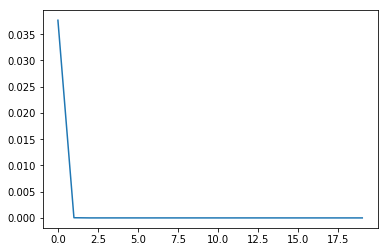

4.427897930145264


In [24]:
batch_size = 32
num_epochs = 20

losses = []

t = time.time()

for epoch in range(num_epochs):

    # Randomize
    indexes = np.arange(train_labels.shape[0])
    np.random.shuffle(indexes)

    train_data = train_data[indexes]
    train_labels = train_labels[indexes]

    for i in range(int(train_data.shape[0]/batch_size)):
        
        batch = train_data[range(i*batch_size,(i+1)*batch_size)]
        batch_labels = train_labels[range(i*batch_size,(i+1)*batch_size)]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(torch.tensor(batch, dtype=torch.float32))
        train_loss = criterion(outputs, torch.max(torch.tensor(batch_labels), 1)[1])
        train_loss.backward()
        optimizer.step()

    losses.append(train_loss)
    print('Epoch %d, loss %g' % (epoch, train_loss))

elapsed = time.time() - t

plt.plot(losses)
plt.show()

print(elapsed)